In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/System-Threat-Forecaster/sample_submission.csv
/kaggle/input/System-Threat-Forecaster/train.csv
/kaggle/input/System-Threat-Forecaster/test.csv


**LOADING DATASET**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
train=pd.read_csv('/kaggle/input/System-Threat-Forecaster/train.csv')
sample=pd.read_csv('/kaggle/input/System-Threat-Forecaster/sample_submission.csv')
test=pd.read_csv('/kaggle/input/System-Threat-Forecaster/test.csv')
train_labels = train['target']
train.drop(['target'], axis=1, inplace=True)

**EXAMINE THE DATASETS(EDA)**

In [3]:
# Basic Information about the Data like shape and number of missing values per column
print("Train Dataset Shape:", train.shape)
print("Test Dataset Shape:", test.shape)
# missing values
print("\nMissing Values in Train Data:")
print(train.isnull().sum()[train.isnull().sum() > 0])

print("\nMissing Values in Test Data:")
print(test.isnull().sum()[test.isnull().sum() > 0])

Train Dataset Shape: (100000, 75)
Test Dataset Shape: (10000, 75)

Missing Values in Train Data:
RealTimeProtectionState                66
AntivirusConfigID                      76
NumAntivirusProductsInstalled          76
NumAntivirusProductsEnabled            76
CityID                                623
IsSystemProtected                      76
SMode                                 981
IEVersionID                           107
FirewallEnabled                       166
EnableLUA                              19
OEMNameID                             212
OEMModelID                            228
ProcessorCoreCount                     85
ProcessorManufacturerID                85
ProcessorModelID                       85
PrimaryDiskCapacityMB                 110
PrimaryDiskType                        23
SystemVolumeCapacityMB                110
TotalPhysicalRAMMB                    151
ChassisType                             2
PrimaryDisplayDiagonalInches           72
PrimaryDisplayResolut

In [4]:
train.head()

,MachineID,ProductName,EngineVersion,AppVersion,SignatureVersion,IsBetaUser,RealTimeProtectionState,IsPassiveModeEnabled,AntivirusConfigID,NumAntivirusProductsInstalled,...,FirmwareVersionID,IsSecureBootEnabled,IsVirtualDevice,IsTouchEnabled,IsPenCapable,IsAlwaysOnAlwaysConnectedCapable,IsGamer,RegionIdentifier,DateAS,DateOS
0,f541bae429089117c4aac39c90dd3416,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1003.0,0,7.0,0,53447.0,1.0,...,21964.0,0,0.0,1,0,1.0,0.0,6.0,2018-09-10 10:11:00,2018-04-17
1,dc2b14d9ce3a0ce4050bb640190f2ca5,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1465.0,0,7.0,0,53447.0,1.0,...,44548.0,1,0.0,0,0,0.0,0.0,10.0,2018-08-16 00:01:00,2018-08-14
2,fd20c5f010e9c5f91ad1c6b3e0da68a0,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1546.0,0,7.0,0,53447.0,1.0,...,9414.0,0,0.0,0,0,0.0,1.0,6.0,2018-09-20 23:20:00,2018-09-11
3,38711eae85eb77a72ec5dfdf27eb2a76,win8defender,1.1.15200.1,4.12.17007.18011,1.275.1141.0,0,7.0,0,46413.0,2.0,...,33060.0,1,0.0,0,0,0.0,0.0,12.0,2018-09-14 00:32:00,2018-01-03
4,32607c9a543a9214e2c7e45800ed4849,win8defender,1.1.15200.1,4.13.17134.228,1.275.1283.0,0,7.0,0,40466.0,2.0,...,13224.0,0,0.0,0,0,0.0,1.0,7.0,2018-09-15 19:34:00,2018-09-11


In [5]:
test.head()

,MachineID,ProductName,EngineVersion,AppVersion,SignatureVersion,IsBetaUser,RealTimeProtectionState,IsPassiveModeEnabled,AntivirusConfigID,NumAntivirusProductsInstalled,...,FirmwareVersionID,IsSecureBootEnabled,IsVirtualDevice,IsTouchEnabled,IsPenCapable,IsAlwaysOnAlwaysConnectedCapable,IsGamer,RegionIdentifier,DateAS,DateOS
0,c2c61173092ad20db5585ca8c10de6e0,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1276.0,0,7.0,0,53447.0,1.0,...,48751.0,0,0.0,0,0,0.0,1.0,11.0,2018-08-12 13:12:00,2018-07-10
1,2e6bb5362ba1ce897feeb1de5edea686,win8defender,1.1.15100.1,4.10.209.0,1.273.371.0,0,7.0,0,46184.0,2.0,...,64709.0,1,0.0,0,0,0.0,0.0,12.0,2018-07-26 06:54:00,2016-10-11
2,692649baed1c50bb8d051ae7f06e3625,win8defender,1.1.15200.1,4.18.1807.18075,1.275.263.0,0,7.0,0,51954.0,2.0,...,33094.0,1,0.0,0,0,0.0,0.0,10.0,2018-08-27 17:29:00,2018-05-08
3,2ff95e7d97e9f80ec81c97622dd93ed6,win8defender,1.1.15300.6,4.18.1807.18075,1.277.58.0,0,7.0,0,41571.0,2.0,...,26184.0,1,0.0,0,0,0.0,0.0,10.0,2018-09-25 22:13:00,2018-05-08
4,256766b4c5011e146f05b323863e08a4,win8defender,1.1.14800.3,4.14.17639.18041,1.267.898.0,0,7.0,0,40645.0,3.0,...,12126.0,0,0.0,0,0,0.0,0.0,7.0,2018-05-06 01:31:00,2018-06-12


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 75 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   MachineID                           10000 non-null  object 
 1   ProductName                         10000 non-null  object 
 2   EngineVersion                       10000 non-null  object 
 3   AppVersion                          10000 non-null  object 
 4   SignatureVersion                    10000 non-null  object 
 5   IsBetaUser                          10000 non-null  int64  
 6   RealTimeProtectionState             9991 non-null   float64
 7   IsPassiveModeEnabled                10000 non-null  int64  
 8   AntivirusConfigID                   9998 non-null   float64
 9   NumAntivirusProductsInstalled       9998 non-null   float64
 10  NumAntivirusProductsEnabled         9998 non-null   float64
 11  HasTpm                              10000 

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 75 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   MachineID                           100000 non-null  object 
 1   ProductName                         100000 non-null  object 
 2   EngineVersion                       100000 non-null  object 
 3   AppVersion                          100000 non-null  object 
 4   SignatureVersion                    100000 non-null  object 
 5   IsBetaUser                          100000 non-null  int64  
 6   RealTimeProtectionState             99934 non-null   float64
 7   IsPassiveModeEnabled                100000 non-null  int64  
 8   AntivirusConfigID                   99924 non-null   float64
 9   NumAntivirusProductsInstalled       99924 non-null   float64
 10  NumAntivirusProductsEnabled         99924 non-null   float64
 11  HasTpm                     

In [8]:
for col in test.columns:
    print(col.ljust(30), (len(set(train[col])) , (set(train[col])) == (set(test[col]))))

MachineID                      (99835, False)
ProductName                    (2, True)
EngineVersion                  (37, False)
AppVersion                     (69, False)
SignatureVersion               (2735, False)
IsBetaUser                     (1, True)
RealTimeProtectionState        (72, False)
IsPassiveModeEnabled           (2, True)
AntivirusConfigID              (2052, False)
NumAntivirusProductsInstalled  (81, False)
NumAntivirusProductsEnabled    (81, False)
HasTpm                         (2, True)
CountryID                      (220, False)
CityID                         (16670, False)
GeoRegionID                    (239, False)
LocaleEnglishNameID            (185, False)
PlatformType                   (4, True)
Processor                      (3, True)
OSVersion                      (7, False)
OSBuildNumber                  (24, False)
OSProductSuite                 (7, False)
OsPlatformSubRelease           (9, True)
OSBuildLab                     (281, False)
SKUEditionNam

**VISUALIZATION**

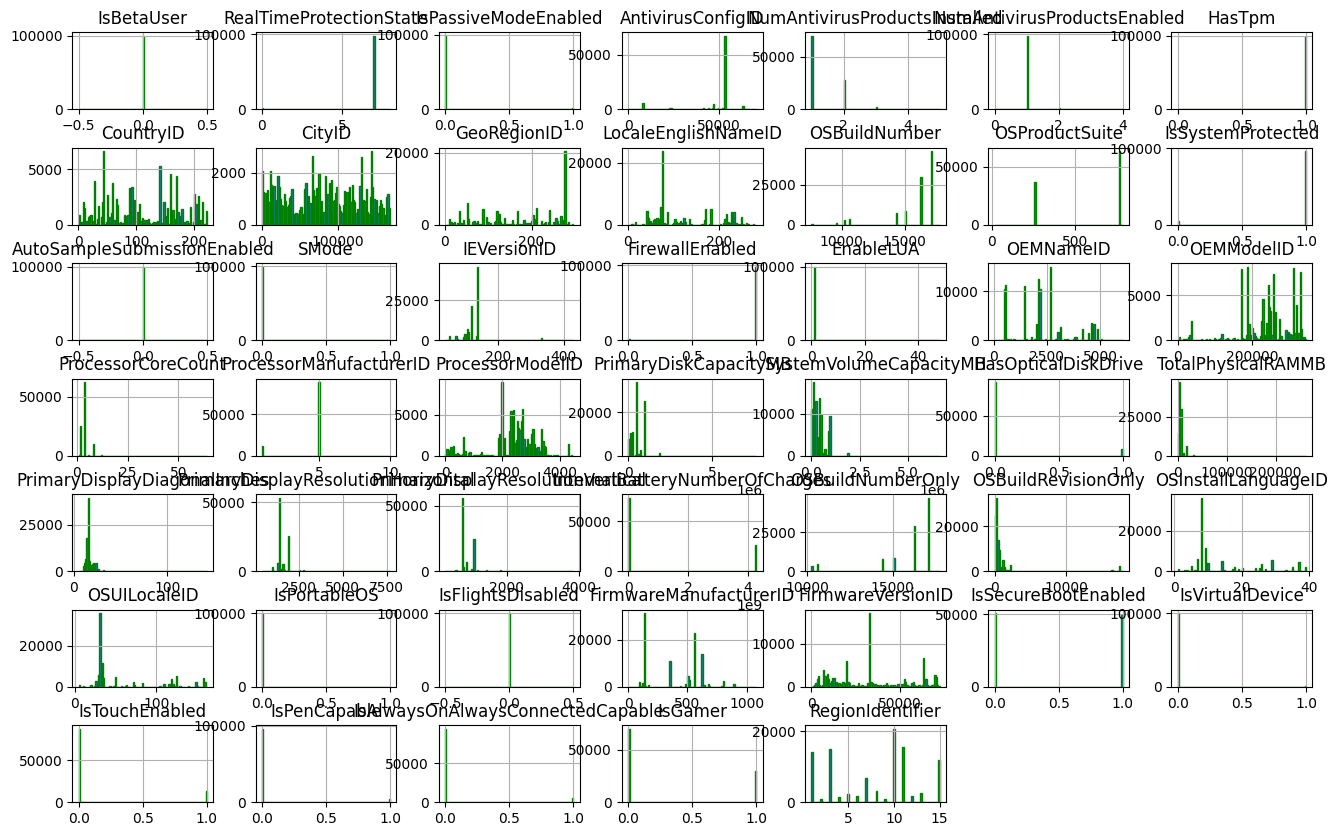

In [9]:
import matplotlib.pyplot as plt

train.hist(bins=100, edgecolor='green', figsize=(16, 10))
plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()

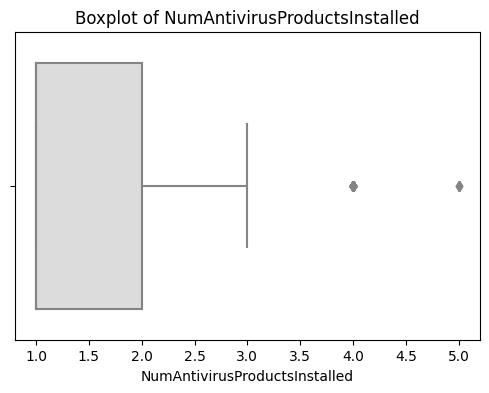

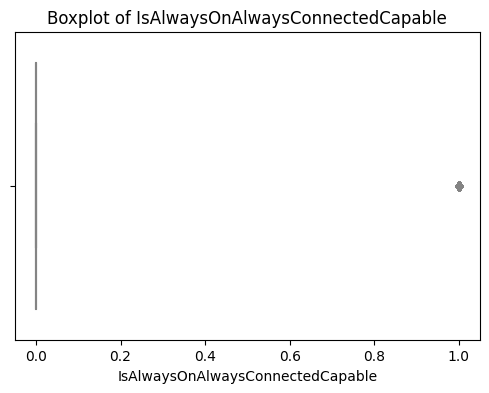

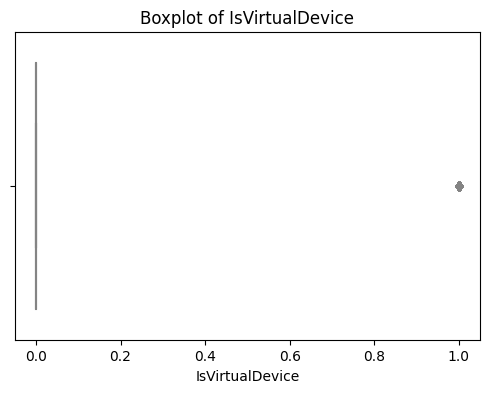

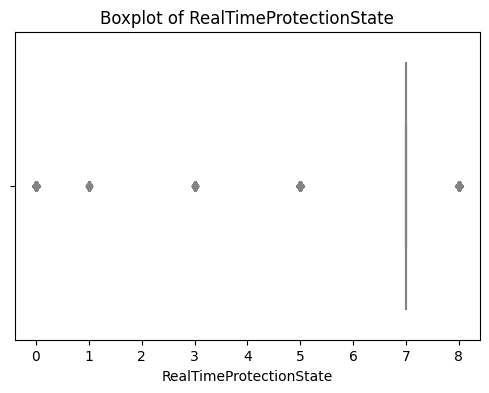

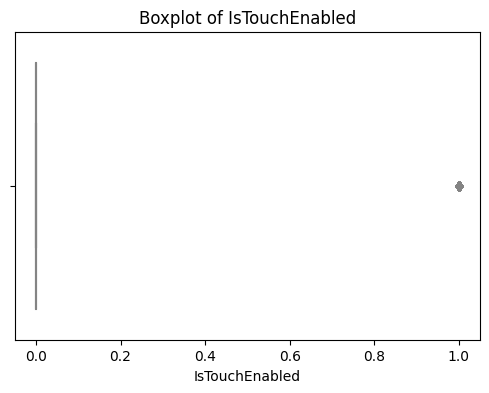

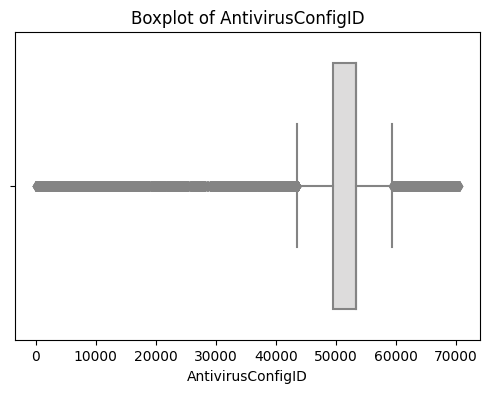

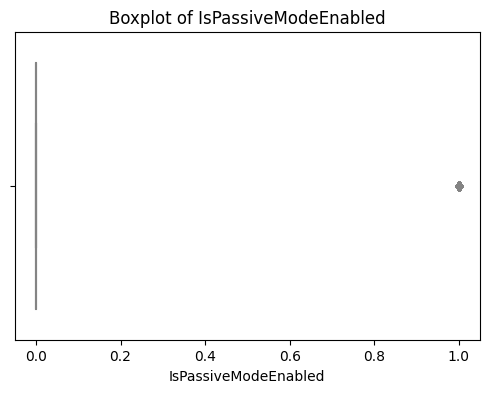

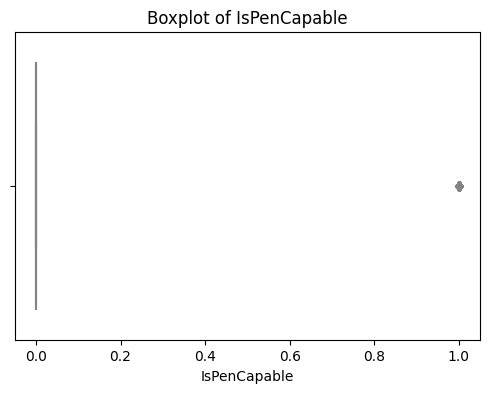

In [10]:
# Box plot for the important columns to check for the outliers
numeric_cols = [
    'NumAntivirusProductsInstalled', 'IsAlwaysOnAlwaysConnectedCapable', 
    'IsVirtualDevice', 'RealTimeProtectionState', 'IsTouchEnabled', 
    'AntivirusConfigID', 'IsPassiveModeEnabled', 'IsPenCapable'
]

for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=train[col], palette="coolwarm")
    plt.title(f"Boxplot of {col}")
    plt.show()


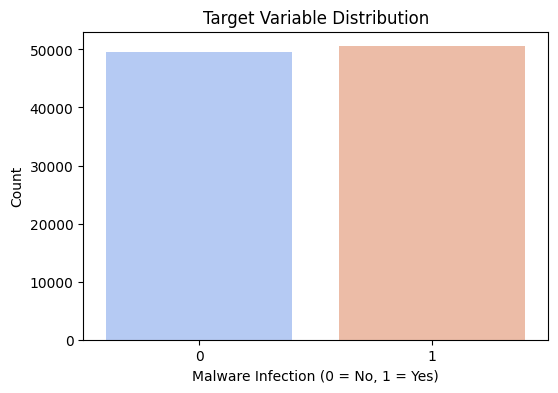

In [11]:
# Check the distribution of the target variable to understand class balance.
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x=train_labels, palette="coolwarm")
plt.title("Target Variable Distribution")
plt.xlabel("Malware Infection (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

**FEATURE SELECTION AND ENCODING**

In [12]:
# Dropping MachineID since it doesn't contribute to predictions
to_drop = ['MachineID']

# categorical features
categorical_features = ['AppVersion', 'SignatureVersion']

#numerical features (based on feature importance)
numerical_features = [
    'NumAntivirusProductsInstalled', 'IsAlwaysOnAlwaysConnectedCapable', 'IsVirtualDevice',
    'RealTimeProtectionState', 'IsTouchEnabled', 'AntivirusConfigID', 
    'IsPassiveModeEnabled', 'IsPenCapable'
]

# Drop unnecessary columns
train.drop(to_drop, axis=1, inplace=True)
test.drop(to_drop, axis=1, inplace=True)


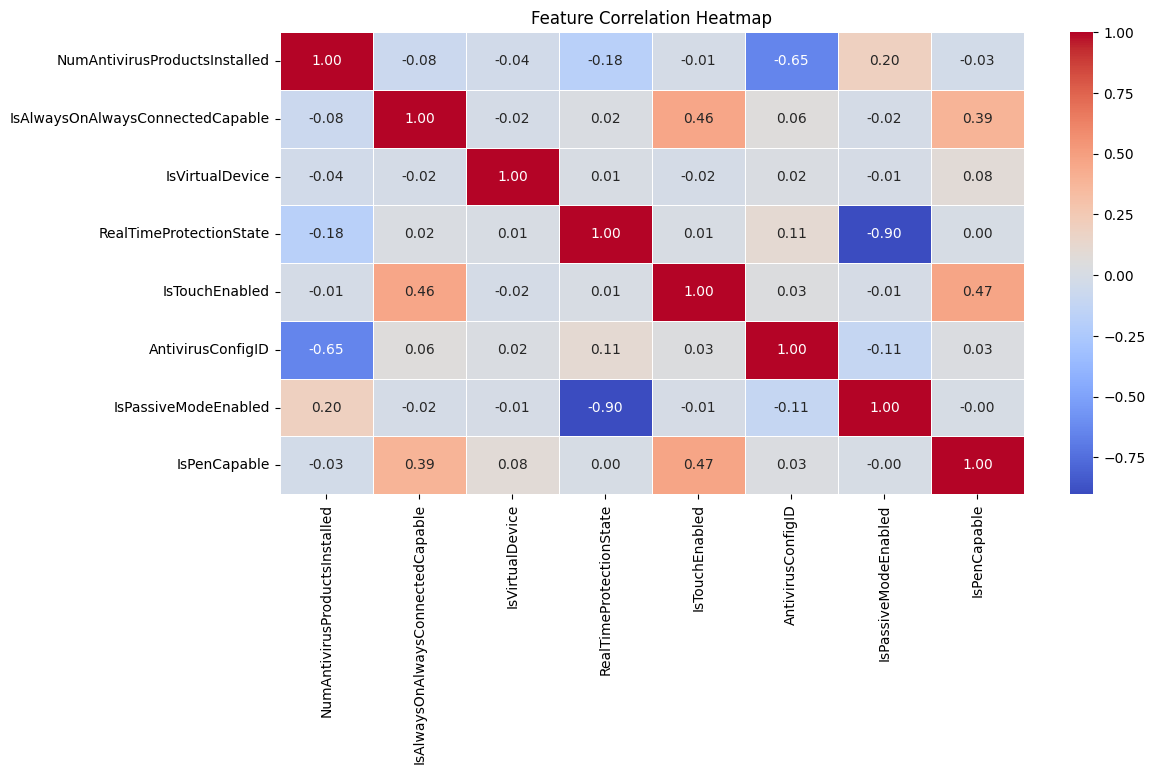

In [13]:
corr_matrix = train[numerical_features].corr()

corr_matrix = corr_matrix.fillna(0)

plt.figure(figsize=(12, 6))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

**DATA PREPROCESSING PIPELINE**

In [14]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Categorical features pipeline: Impute missing values and apply encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing with most frequent value
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))  # Encode categories
])

# Numerical features pipeline: Fill missing values and scale
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())  # Standardize numerical features
])

# Combine both into a ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

# Transform train and test data
train_processed = pd.DataFrame(preprocessor.fit_transform(train))
test_processed = pd.DataFrame(preprocessor.transform(test))

# Ensure column names remain consistent
train_processed.columns = range(train_processed.shape[1])
test_processed.columns = range(test_processed.shape[1])


**SPLITTING DATA**

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_processed, train_labels, test_size=0.2, random_state=42, stratify=train_labels)

In [16]:
# Train a basic XGBoost model to get feature importances
xgb_model = XGBClassifier(n_estimators=100, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)

# Get feature importance scores
feature_importances = pd.Series(xgb_model.feature_importances_, index=train_processed.columns)

# Select the top 10 most important numerical features
top_numerical_features = feature_importances.nlargest(10).index
print(top_numerical_features)


Index([0, 2, 1, 4, 9, 5, 3, 7, 8, 6], dtype='int64')


In [17]:
# Get numerical and categorical feature names
numerical_feature_names = numerical_features  # Defined earlier
categorical_feature_names = categorical_features  # Defined earlier

# Combine both feature lists in the same order they were processed
all_feature_names = numerical_feature_names + categorical_feature_names

# Print total number of features for debugging
print("Total number of features:", len(all_feature_names))
print("Feature names:", all_feature_names)

# make sure that the indexes are within range
valid_indices = [i for i in [4, 9, 6, 14, 1, 7, 3, 2, 8, 13] if i < len(all_feature_names)]

# Convert feature indexes to actual names
important_feature_names = [all_feature_names[i] for i in valid_indices]

# Print the names
print("Most Important Features:", important_feature_names)


Total number of features: 10
Feature names: ['NumAntivirusProductsInstalled', 'IsAlwaysOnAlwaysConnectedCapable', 'IsVirtualDevice', 'RealTimeProtectionState', 'IsTouchEnabled', 'AntivirusConfigID', 'IsPassiveModeEnabled', 'IsPenCapable', 'AppVersion', 'SignatureVersion']
Most Important Features: ['IsTouchEnabled', 'SignatureVersion', 'IsPassiveModeEnabled', 'IsAlwaysOnAlwaysConnectedCapable', 'IsPenCapable', 'RealTimeProtectionState', 'IsVirtualDevice', 'AppVersion']


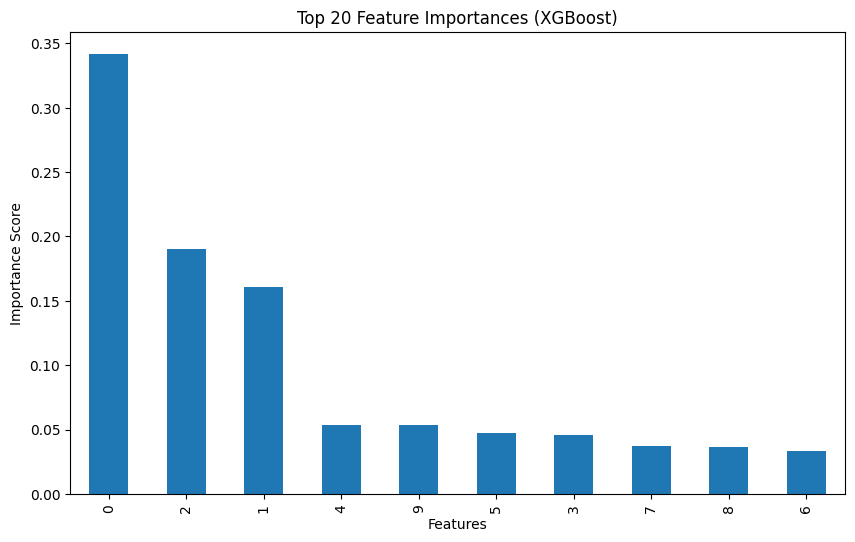

In [18]:
import matplotlib.pyplot as plt

# Sorting the inportant features
feature_importances.sort_values(ascending=False, inplace=True)

# Plotting the graph
plt.figure(figsize=(10, 6))
feature_importances[:20].plot(kind='bar')  # Showing the top 20 features
plt.title("Top 20 Feature Importances (XGBoost)")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.show()

**HYPERPARAMETER TUNING**

In [19]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from xgboost import XGBClassifier
import numpy as np

# Define the hyperparameter grid
xgb_params = {
    'max_depth': [3, 6, 9, 12, 15],
    'learning_rate': np.linspace(0.01, 0.2, 10),
    'n_estimators': [100, 300, 500, 700],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_lambda': [1, 5, 10],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'min_child_weight': [1, 3, 5],
    'scale_pos_weight': [1, 3, 5, 10],
    'max_delta_step': [0, 1, 5, 10]
}

# Use Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize RandomizedSearchCV
xgb_random = RandomizedSearchCV(
    XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    xgb_params,
    n_iter=50,  # Number of parameter combinations to try
    cv=skf,  # Stratified K-Fold Cross-Validation
    scoring='accuracy',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit on training data
xgb_random.fit(X_train, y_train)

# Print best parameters
print("Best XGBoost Parameters:", xgb_random.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best XGBoost Parameters: {'subsample': 0.8, 'scale_pos_weight': 1, 'reg_lambda': 10, 'reg_alpha': 0.1, 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 6, 'max_delta_step': 10, 'learning_rate': 0.01, 'gamma': 0.3, 'colsample_bytree': 1.0}


**MODELS**

**XG BOOST**

In [20]:
# Training the final model using best parameters
best_params = xgb_random.best_params_

xgb_model = XGBClassifier(
    **best_params,  # Use best found parameters
    random_state=42, 
    use_label_encoder=False, 
    eval_metric='logloss',
    early_stopping_rounds=30
)

# Fit the model with early stopping
xgb_model.fit(
    X_train, y_train, 
    eval_set=[(X_val, y_val)], 
    verbose=100
)


[0]	validation_0-logloss:0.69255
[100]	validation_0-logloss:0.66787
[200]	validation_0-logloss:0.66215
[300]	validation_0-logloss:0.65995
[400]	validation_0-logloss:0.65897
[499]	validation_0-logloss:0.65855


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=30,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.3, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=10, max_depth=6,
              max_leaves=None, min_child_weight=3, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

**RANDOM FORREST**

In [21]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=42)

**LOGISTIC REGRESSION**

In [22]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

**EVALUATION**

In [23]:
from sklearn.metrics import classification_report

# XGBoost
print("XGBoost Model Performance:")
print(classification_report(y_val, xgb_model.predict(X_val)))

# Random Forest
print("Random Forest Performance:")
print(classification_report(y_val, rf_model.predict(X_val)))

# Logistic Regression
print("Logistic Regression Performance:")
print(classification_report(y_val, log_model.predict(X_val)))



XGBoost Model Performance:
              precision    recall  f1-score   support

           0       0.64      0.49      0.56      9895
           1       0.60      0.73      0.66     10105

    accuracy                           0.61     20000
   macro avg       0.62      0.61      0.61     20000
weighted avg       0.62      0.61      0.61     20000

Random Forest Performance:
              precision    recall  f1-score   support

           0       0.65      0.48      0.55      9895
           1       0.59      0.74      0.66     10105

    accuracy                           0.61     20000
   macro avg       0.62      0.61      0.61     20000
weighted avg       0.62      0.61      0.61     20000

Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.62      0.44      0.51      9895
           1       0.57      0.73      0.64     10105

    accuracy                           0.59     20000
   macro avg       0.59      0.59      0.

**XGB Model Key Insights**
The model has high recall for Class 1 (73%), meaning it detects more positive cases but misclassifies more negatives.
Precision for Class 0 is higher, meaning fewer false positives.
Balanced model but slightly favors Class 1.
**Accuracy:61%**

**Random Forrest Key Insights**
Slightly better precision than XGBoost for Class 0 but similar overall performance.
This model also favors recall for Class 1, meaning it prioritizes finding positives at the cost of misclassifying some negatives.**Accuracy:61%**

**Logistic Regression Key Insights**
Logistic Regression performs worse than XGBoost & Random Forest.
It detects positives well but fails to classify negatives.**Accuracy:59%**

In [24]:
import pandas as pd
import numpy as np

# Load test data (ensure correct file path)
test_original = pd.read_csv('/kaggle/input/System-Threat-Forecaster/test.csv')

# Load sample submission to ensure correct format
sample_submission = pd.read_csv('/kaggle/input/System-Threat-Forecaster/sample_submission.csv')

# Create submission DataFrame with correct column names
submission = pd.DataFrame()
submission['id'] = sample_submission['id']  # Ensuring ID matches the required format
submission['target'] = xgb_model.predict(test_processed)  # Make predictions

# Ensure predictions are in the valid probability range (0 to 1)
submission['target'] = np.clip(submission['target'], 0, 1)

# Save submission file
submission.to_csv('submission.csv', index=False)

print("Submission file 'submission.csv' generated successfully!")

Submission file 'submission.csv' generated successfully!
